In [157]:
import string
import re
import os
import nltk
import pandas as pd
import numpy as np
import json
import glob
import gzip
import tensorflow as tf
from tensorflow import keras
import time

import matplotlib.pyplot as plt

SEED = 1013
np.random.seed(SEED)

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import pandas as pd 
import numpy as np 
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy import sparse
import os
import pickle
import emoji
from wordcloud import WordCloud

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.util import ngrams

nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Meghna/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [158]:
import collections
df=pd.read_csv('/Users/Meghna/Desktop/Mental_Model_Generation2.csv')
responses=df.iloc[2:,12:]

reordered_responses=responses[['Q34','Q58','Q12','Q13','Q14','Q16','Q35','Q18','Q19','Q20','Q21','Q30','Q34','Q17','Q15','Q1','Q39','Q28','Q3','Q4','Q5','Q6','Q9','Q29_1','Q29_2','Q29_3','Q29_4','Q29_5','Q29_6','Q29_7']]

free_form_responses=reordered_responses.iloc[:,:12]

single_choice_responses=reordered_responses.iloc[:,12:]

individual_responses=collections.defaultdict(list)
free_form_responses_without_race=free_form_responses.iloc[:,1:]
race=free_form_responses.iloc[:,0].tolist()
r=-1
for index, row in free_form_responses_without_race.iterrows():
    r+=1
    for i in range(len(row)):
        try:
            if float(row[i])==row[i]:
                #print(row[i])
                continue
        except ValueError:
            individual_responses[(index,race[r])].append(row[i])

In [159]:
print(len(individual_responses))

77


In [160]:
survey_data_raw = []
survey_labels = []
for i in individual_responses:
    for z in individual_responses[i]:
#         if type(val)!= float and not val.startswith('Q') and val != 'NaN':
#             print(val)
        survey_data_raw.append(z)
        if i[1] == 'Black or African American':
            survey_labels.append(1)
        else:
            survey_labels.append(0)

In [161]:
survey_box_plot = [len(t) for t in survey_data_raw]

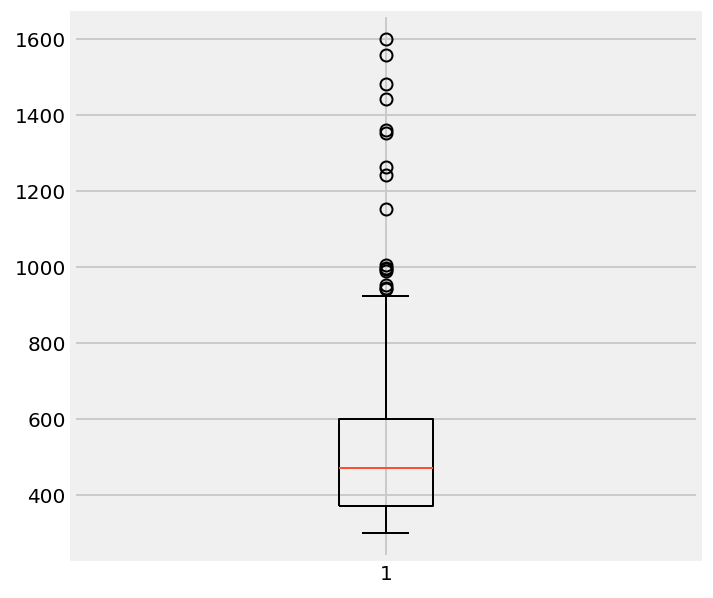

In [162]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(survey_box_plot)
plt.show()

In [163]:
print(survey_data_raw[4])

I have not heard about this. It would not surprise me if there is some sort of institutional racism at some level. I think just anger and relentment has been boiling due to the pandemic and people being stuck at home and people are now not sure whether to trust the information they are being told. I think they are right not to trust the information and to question it because people are getting a vaccine without any clue of whats in it or what effects it has on a person. In that sense, the vaccine was far too rushed and we dont know the effects on a large sample size. Ironically,the reasons why universal basic income has not been implemented.


In [164]:
print(len(survey_data_raw))
print(len(set(survey_data_raw)))
print(len(survey_labels))

720
651
720


In [165]:
pd.set_option('display.max_colwidth', None)
df1 = pd.DataFrame(columns=['text','label'])
df1['text'] =  survey_data_raw
df1['label'] = survey_labels
df1['pre_clean_len'] = [len(t) for t in df1.text]
df1[df1.pre_clean_len > 280]

,text,label,pre_clean_len
0,I protect myself by wearing a mask and by social distancing. I also wash my hands continuously and keep a window open to get fresh air in the house. I also try to wear gloves when touching items outside the house. I also try to limit exposure to other people and limit touching other items or people. I treat the disease as if I have the disease so will not spread the disease.,0,377
1,"I would if I needed it. I think local officials or medical facilities are important as they not only save lives they also enable vaccinations which helps contain the virus and stops it from spreading. Therefore, I would be willing to use the medical facilities. The problem is that I am probably not in the right age range to be eligible.",0,338
2,I think people would not believe me because I am not in the right age range so they think I should not be entitled in healthcare. This is another problem of the virus is that people dislike others more and have more hate and contempt. I used to hear people say the virus would bring others together but I believe it stems more hate and contempt from others.,0,358
3,"Obviously, its a no brainer that its true, but I am a little tired of keep reading articles like this without anyone doing anything about it. This could all be ended with a Universal Basic Income but they just give some bs like ok we will trial it here and there, but unless its fully implemented the sample size wont be enough to determine whether its successful or not. So we just keep hearing BS that will go on for decades about how it could work but we need to trial before realizing that obviously it does work and you just wasted a ton of time where the problems above get worse including homeless and severe poverty. I suppose the stimulus checks do help a little though. We will see how long that lasts though. This needs to be replaced by basic income paid by direct deposit or checks none of this prepaid card BS.",0,824
4,"I have not heard about this. It would not surprise me if there is some sort of institutional racism at some level. I think just anger and relentment has been boiling due to the pandemic and people being stuck at home and people are now not sure whether to trust the information they are being told. I think they are right not to trust the information and to question it because people are getting a vaccine without any clue of whats in it or what effects it has on a person. In that sense, the vaccine was far too rushed and we dont know the effects on a large sample size. Ironically,the reasons why universal basic income has not been implemented.",0,649
...,...,...,...
715,"Every body has been using the various sources of funds kept as savings they had before Covid-19 pandemic broke out. I for one person had to use a lot of my savings to help feed my family So its a true statement. And i guess the reason why there was a wide gap during the recession among the different races in america before the pandemic eas because alot of these people had little jobs to do, Covid came and made it worse for everyone. Overall i think the government just needs to strengthen is economic recovery plans to cut across every household regardless of race or ethnicity.",0,582
716,This statement above is true only because of the racial unrest that has been going on in the country before the pandemic broke out. Someone of color will feel reluctant to be tried for the drug at first just so not to look like a lab rat for some random doctor due to the previous racial arguments and issues that have been rampaging our society even before Covid came. My opinion is that we all have to come together regardless of our race or gender or sex orientation so that we can fight this pandemic Together. The government also needs to do alot of public sensitisation to assure people of color and every other person that there trials are safe and are not racially motivated.,0,683
717,"All written statement above seem true as we can already see the effe

In [166]:
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import re
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    stripped = re.sub(r'\@w+','',stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

In [167]:
train_data = []
for data in survey_data_raw:
    train_data.append(tweet_cleaner_updated(data))
    
train_labels = survey_labels

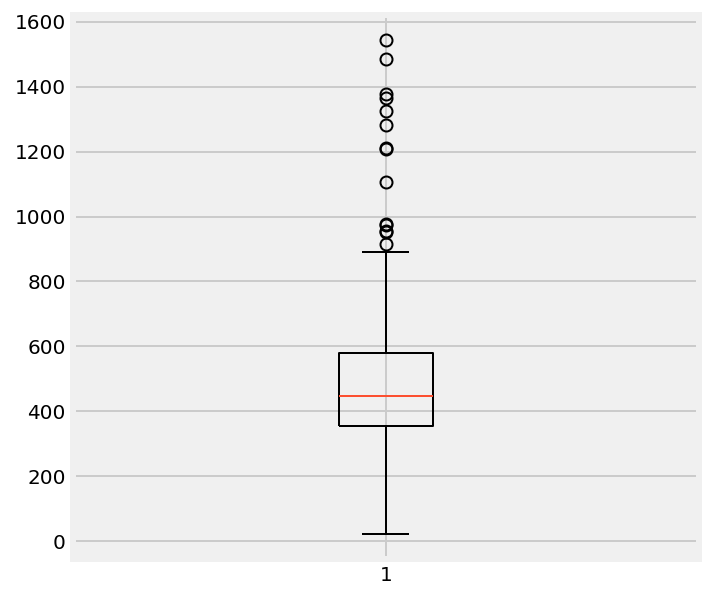

In [168]:
survey_box_plot2 = [len(t) for t in train_data]
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(survey_box_plot2)
plt.show()

In [171]:
df = pd.DataFrame(columns=['text','label'])

df['text'] = train_data
df['label'] = train_labels

df0 = df[df["label"] == 0] 
df1 = df[df["label"] == 1]


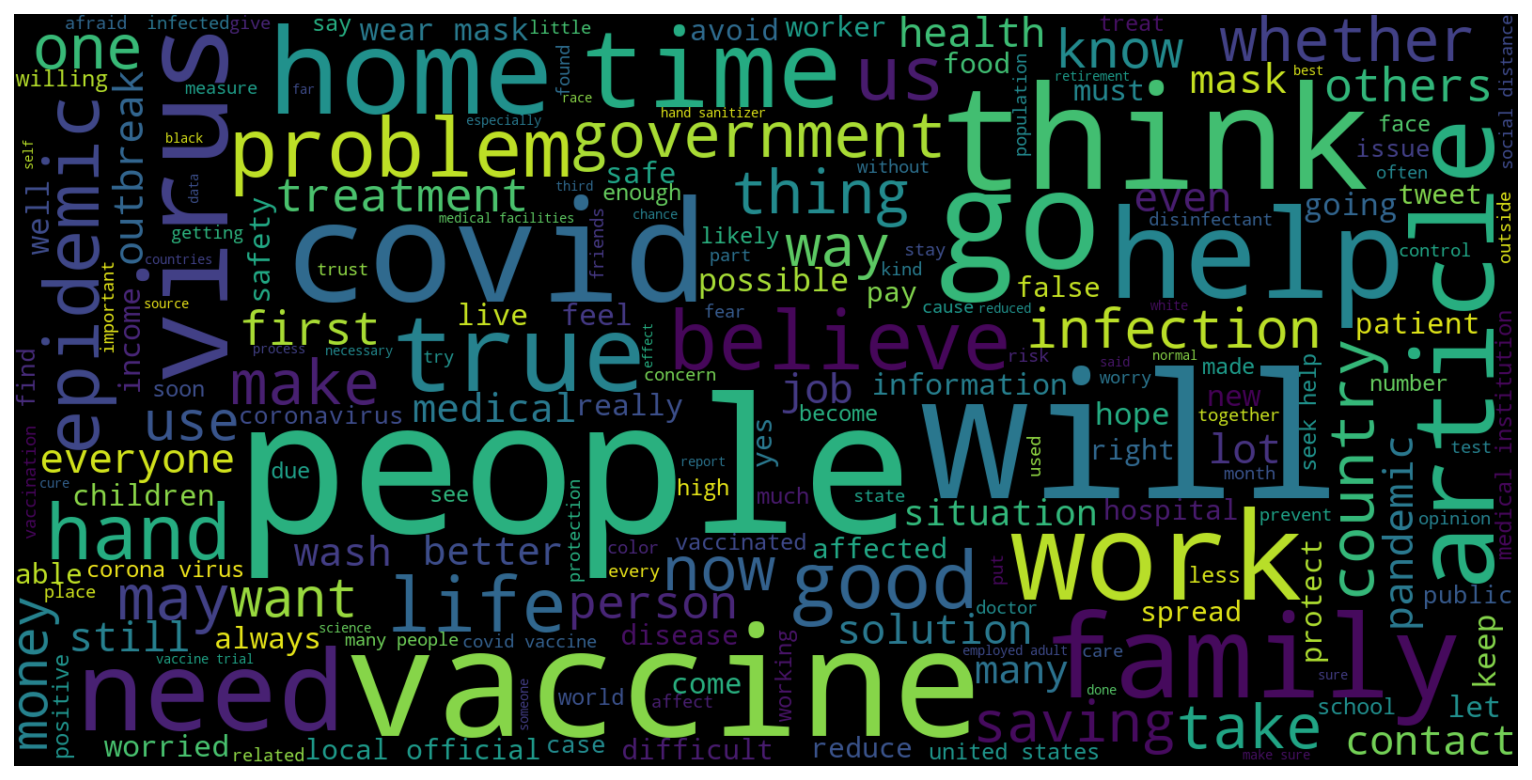

In [172]:
neg_tweets = df[df.label == 0]
neg_string = []
for t in neg_tweets.text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

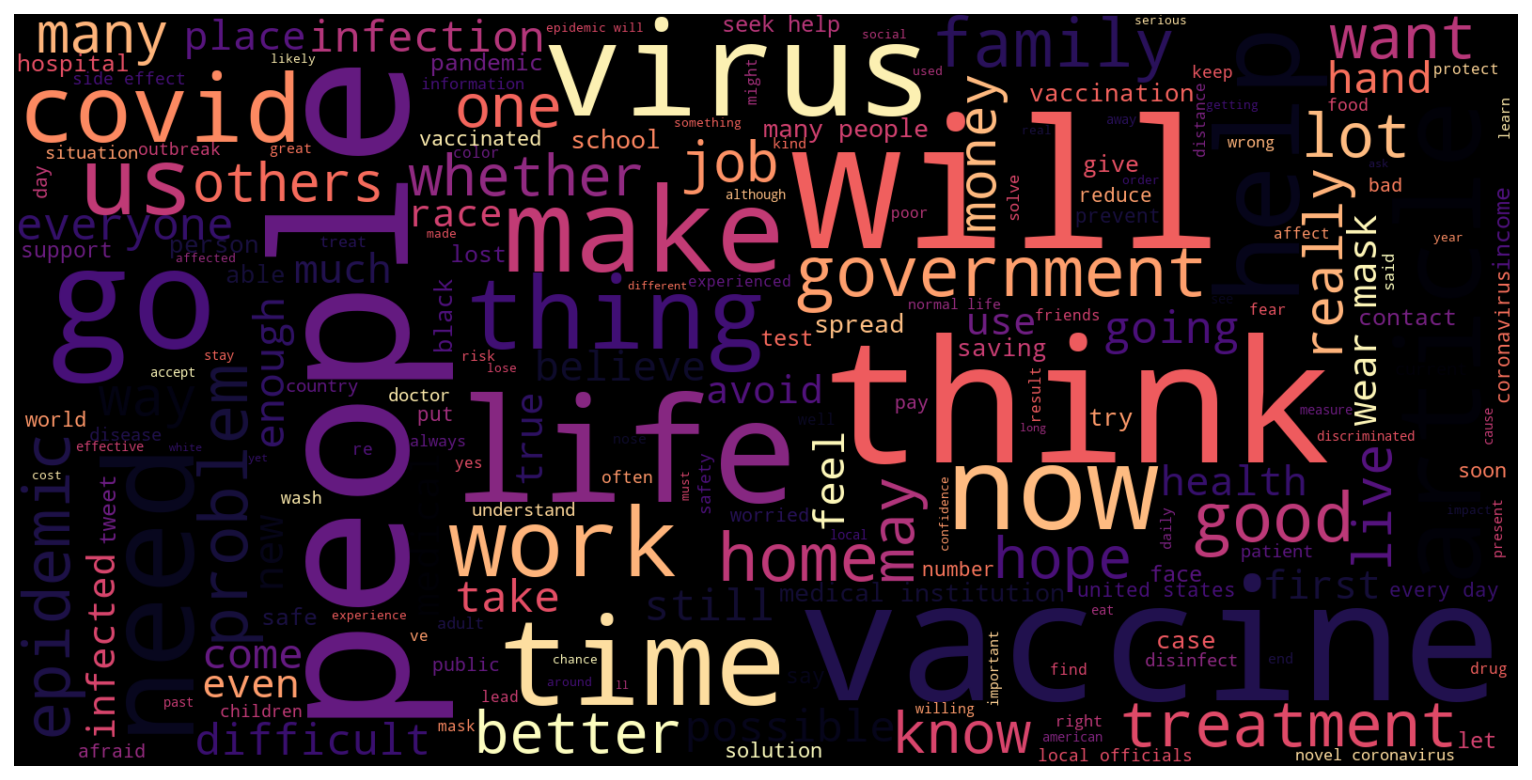

In [173]:
pos_tweets = df[df.label == 1]
pos_string = []
for t in pos_tweets.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(pos_string) 
plt.figure(figsize=(12,10)) 
plt.imshow(wordcloud, interpolation="bilinear") 
plt.axis("off") 
plt.show()

In [175]:
cvec = CountVectorizer()
cvec.fit(df.text)

CountVectorizer()

In [176]:
len(cvec.get_feature_names())

4124

In [178]:
neg_doc_matrix = cvec.transform(df[df.label == 0].text)
pos_doc_matrix = cvec.transform(df[df.label == 1].text)
neg_tf = np.sum(neg_doc_matrix,axis=0)
pos_tf = np.sum(pos_doc_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))
term_freq_df = pd.DataFrame([neg,pos],columns=cvec.get_feature_names()).transpose()

In [179]:
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
the,2123,1288,3411
to,1491,1014,2505
and,1127,802,1929
of,973,693,1666
is,713,472,1185
not,605,442,1047
in,505,348,853
it,482,370,852
that,470,288,758
be,403,263,666


In [180]:
from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english',max_features=3000)
cvec.fit(df.text)

CountVectorizer(max_features=3000, stop_words='english')

In [182]:
document_matrix = cvec.transform(df.text)

In [184]:
neg_doc_matrix2 = cvec.transform(df[df.label == 0].text)
pos_doc_matrix2 = cvec.transform(df[df.label == 1].text)
neg_tf2 = np.sum(neg_doc_matrix2,axis=0)
pos_tf2 = np.sum(pos_doc_matrix2,axis=0)
neg2 = np.squeeze(np.asarray(neg_tf2))
pos2 = np.squeeze(np.asarray(pos_tf2))
term_freq_df2 = pd.DataFrame([neg2,pos2],columns=cvec.get_feature_names()).transpose()
term_freq_df2.columns = ['negative', 'positive']
term_freq_df2['total'] = term_freq_df2['negative'] + term_freq_df2['positive']
term_freq_df2.sort_values(by='total', ascending=False).iloc[:30]

,negative,positive,total
people,320,247,567
vaccine,201,143,344
think,163,166,329
covid,196,63,259
virus,145,98,243
help,145,93,238
life,85,125,210
medical,123,85,208
work,126,63,189
family,118,64,182


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(0.5, 1.0, 'Negative Frequency vs Positive Frequency')

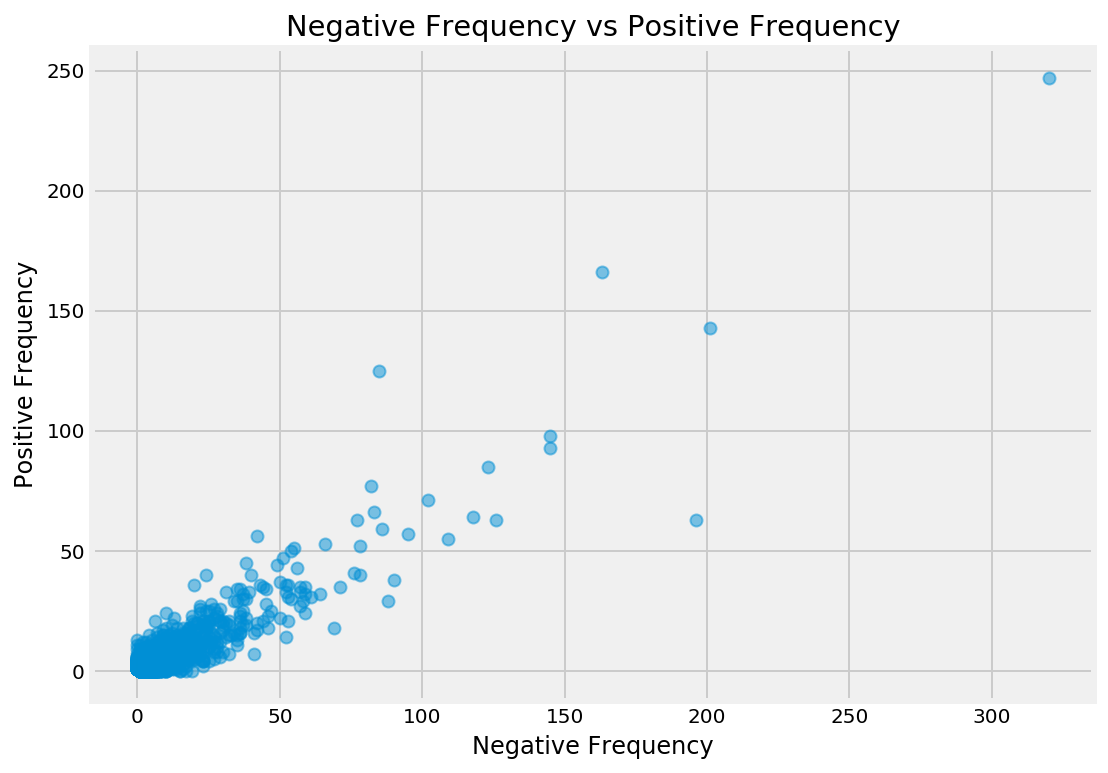

In [185]:
import seaborn as sns
plt.figure(figsize=(8,6))
ax = sns.regplot(x="negative", y="positive",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency')
plt.xlabel('Negative Frequency')
plt.title('Negative Frequency vs Positive Frequency')

In [186]:
term_freq_df2['pos_rate'] = term_freq_df2['positive'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='pos_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate
zhang,0,2,2,1.0
sympathize,0,1,1,1.0
signs,0,2,2,1.0
sigh,0,1,1,1.0
cheerful,0,1,1,1.0
shush,0,1,1,1.0
showing,0,4,4,1.0
chest,0,2,2,1.0
showcase,0,1,1,1.0
shortness,0,2,2,1.0


In [187]:
term_freq_df2['neg_rate'] = term_freq_df2['negative'] * 1./term_freq_df2['total']
term_freq_df2.sort_values(by='neg_rate', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,neg_rate
employee,2,0,2,0.0,1.0
storagea,2,0,2,0.0,1.0
stopped,3,0,3,0.0,1.0
stops,1,0,1,0.0,1.0
draw,3,0,3,0.0,1.0
storage,2,0,2,0.0,1.0
dramatically,2,0,2,0.0,1.0
drags,2,0,2,0.0,1.0
storing,2,0,2,0.0,1.0
dropped,2,0,2,0.0,1.0


In [188]:
term_freq_df2['pos_freq_pct'] = term_freq_df2['positive'] * 1./term_freq_df2['positive'].sum()
term_freq_df2.sort_values(by='pos_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,neg_rate,pos_freq_pct
people,320,247,567,0.435626,0.564374,0.023470
think,163,166,329,0.504559,0.495441,0.015773
vaccine,201,143,344,0.415698,0.584302,0.013588
life,85,125,210,0.595238,0.404762,0.011878
virus,145,98,243,0.403292,0.596708,0.009312
help,145,93,238,0.390756,0.609244,0.008837
medical,123,85,208,0.408654,0.591346,0.008077
time,82,77,159,0.484277,0.515723,0.007317
article,102,71,173,0.410405,0.589595,0.006746
epidemic,83,66,149,0.442953,0.557047,0.006271


In [189]:
term_freq_df2['neg_freq_pct'] = term_freq_df2['negative'] * 1./term_freq_df2['negative'].sum()
term_freq_df2.sort_values(by='neg_freq_pct', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,neg_rate,pos_freq_pct,neg_freq_pct
people,320,247,567,0.435626,0.564374,0.023470,0.019486
vaccine,201,143,344,0.415698,0.584302,0.013588,0.012240
covid,196,63,259,0.243243,0.756757,0.005986,0.011935
think,163,166,329,0.504559,0.495441,0.015773,0.009926
help,145,93,238,0.390756,0.609244,0.008837,0.008830
virus,145,98,243,0.403292,0.596708,0.009312,0.008830
work,126,63,189,0.333333,0.666667,0.005986,0.007673
medical,123,85,208,0.408654,0.591346,0.008077,0.007490
family,118,64,182,0.351648,0.648352,0.006081,0.007185
home,109,55,164,0.335366,0.664634,0.005226,0.006637


In [190]:
from scipy.stats import hmean

term_freq_df2['pos_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['pos_rate'], x['pos_freq_pct']])
                                                                   if x['pos_rate'] > 0 and x['pos_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='pos_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,neg_rate,pos_freq_pct,neg_freq_pct,pos_hmean
people,320,247,567,0.435626,0.564374,0.023470,0.019486,0.044541
think,163,166,329,0.504559,0.495441,0.015773,0.009926,0.030591
vaccine,201,143,344,0.415698,0.584302,0.013588,0.012240,0.026316
life,85,125,210,0.595238,0.404762,0.011878,0.005176,0.023290
virus,145,98,243,0.403292,0.596708,0.009312,0.008830,0.018204
help,145,93,238,0.390756,0.609244,0.008837,0.008830,0.017283
medical,123,85,208,0.408654,0.591346,0.008077,0.007490,0.015840
time,82,77,159,0.484277,0.515723,0.007317,0.004993,0.014415
article,102,71,173,0.410405,0.589595,0.006746,0.006211,0.013275
epidemic,83,66,149,0.442953,0.557047,0.006271,0.005054,0.012368


In [191]:
term_freq_df2['neg_hmean'] = term_freq_df2.apply(lambda x: (hmean([x['neg_rate'], x['neg_freq_pct']])
                                                                   if x['neg_rate'] > 0 and x['neg_freq_pct'] > 0 
                                                                   else 0), axis=1)                                                        
term_freq_df2.sort_values(by='neg_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,neg_rate,pos_freq_pct,neg_freq_pct,pos_hmean,neg_hmean
people,320,247,567,0.435626,0.564374,0.023470,0.019486,0.044541,0.037671
vaccine,201,143,344,0.415698,0.584302,0.013588,0.012240,0.026316,0.023977
covid,196,63,259,0.243243,0.756757,0.005986,0.011935,0.011685,0.023500
think,163,166,329,0.504559,0.495441,0.015773,0.009926,0.030591,0.019462
help,145,93,238,0.390756,0.609244,0.008837,0.008830,0.017283,0.017407
virus,145,98,243,0.403292,0.596708,0.009312,0.008830,0.018204,0.017402
work,126,63,189,0.333333,0.666667,0.005986,0.007673,0.011761,0.015171
medical,123,85,208,0.408654,0.591346,0.008077,0.007490,0.015840,0.014793
family,118,64,182,0.351648,0.648352,0.006081,0.007185,0.011956,0.014213
home,109,55,164,0.335366,0.664634,0.005226,0.006637,0.010292,0.013144


In [192]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())
term_freq_df2['pos_rate_normcdf'] = normcdf(term_freq_df2['pos_rate'])
term_freq_df2['pos_freq_pct_normcdf'] = normcdf(term_freq_df2['pos_freq_pct'])
term_freq_df2['pos_normcdf_hmean'] = hmean([term_freq_df2['pos_rate_normcdf'], term_freq_df2['pos_freq_pct_normcdf']])
term_freq_df2.sort_values(by='pos_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,neg_rate,pos_freq_pct,neg_freq_pct,pos_hmean,neg_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean
discrimination,6,21,27,0.777778,0.222222,0.001995,0.000365,0.003981,0.000730,0.865153,0.964414,0.912091
discriminated,0,13,13,1.000000,0.000000,0.001235,0.000000,0.002467,0.000000,0.957832,0.836245,0.892918
lost,10,24,34,0.705882,0.294118,0.002281,0.000609,0.004546,0.001215,0.816587,0.982735,0.891990
quite,4,15,19,0.789474,0.210526,0.001425,0.000244,0.002845,0.000487,0.872131,0.882080,0.877077
black,20,36,56,0.642857,0.357143,0.003421,0.001218,0.006805,0.002427,0.766064,0.999598,0.867387
skin,0,11,11,1.000000,0.000000,0.001045,0.000000,0.002088,0.000000,0.957832,0.780189,0.859932
infected,24,40,64,0.625000,0.375000,0.003801,0.001461,0.007556,0.002912,0.750460,0.999916,0.857413
real,2,12,14,0.857143,0.142857,0.001140,0.000122,0.002277,0.000243,0.907583,0.809481,0.855730
wrong,7,16,23,0.695652,0.304348,0.001520,0.000426,0.003034,0.000851,0.808883,0.901232,0.852564
cowid,1,11,12,0.916667,0.083333,0.001045,0.000061,0.002088,0.000122,0.932243,0.780189,0.849465


In [193]:
from scipy.stats import norm
def normcdf(x):
    return norm.cdf(x, x.mean(), x.std())

term_freq_df2['neg_rate_normcdf'] = normcdf(term_freq_df2['neg_rate'])
term_freq_df2['neg_freq_pct_normcdf'] = normcdf(term_freq_df2['neg_freq_pct'])
term_freq_df2['neg_normcdf_hmean'] = hmean([term_freq_df2['neg_rate_normcdf'], term_freq_df2['neg_freq_pct_normcdf']])
term_freq_df2.sort_values(by='neg_normcdf_hmean', ascending=False).iloc[:10]

,negative,positive,total,pos_rate,neg_rate,pos_freq_pct,neg_freq_pct,pos_hmean,neg_hmean,pos_rate_normcdf,pos_freq_pct_normcdf,pos_normcdf_hmean,neg_rate_normcdf,neg_freq_pct_normcdf,neg_normcdf_hmean
workers,41,7,48,0.145833,0.854167,0.000665,0.002497,0.001324,0.004979,0.252741,0.640657,0.362482,0.747259,0.995143,0.853568
healthcare,19,0,19,0.000000,1.000000,0.000000,0.001157,0.000000,0.002311,0.141351,0.358726,0.202794,0.858649,0.837572,0.847980
employed,23,2,25,0.080000,0.920000,0.000190,0.001401,0.000379,0.002797,0.197595,0.438191,0.272369,0.802405,0.898965,0.847945
self,25,4,29,0.137931,0.862069,0.000380,0.001522,0.000758,0.003039,0.245721,0.520238,0.333786,0.754279,0.922379,0.829902
concerns,17,0,17,0.000000,1.000000,0.000000,0.001035,0.000000,0.002068,0.141351,0.358726,0.202794,0.858649,0.799252,0.827887
disinfectant,27,5,32,0.156250,0.843750,0.000475,0.001644,0.000947,0.003282,0.262154,0.561158,0.357361,0.737846,0.941423,0.827295
false,32,7,39,0.179487,0.820513,0.000665,0.001949,0.001325,0.003888,0.283781,0.640657,0.393333,0.716219,0.973244,0.825181
online,29,6,35,0.171429,0.828571,0.000570,0.001766,0.001136,0.003524,0.276185,0.601434,0.378540,0.723815,0.956589,0.824080
country,69,18,87,0.206897,0.793103,0.001710,0.004202,0.003393,0.008359,0.310339,0.932531,0.465697,0.689661,0.999998,0.816330
worry,23,4,27,0.148148,0.851852,0.000380,0.001401,0.000758,0.002797,0.254817,0.520238,0.342081,0.745183,0.898965,0.814882


Text(0.5, 1.0, 'neg_freq_pct vs pos_freq_pct')

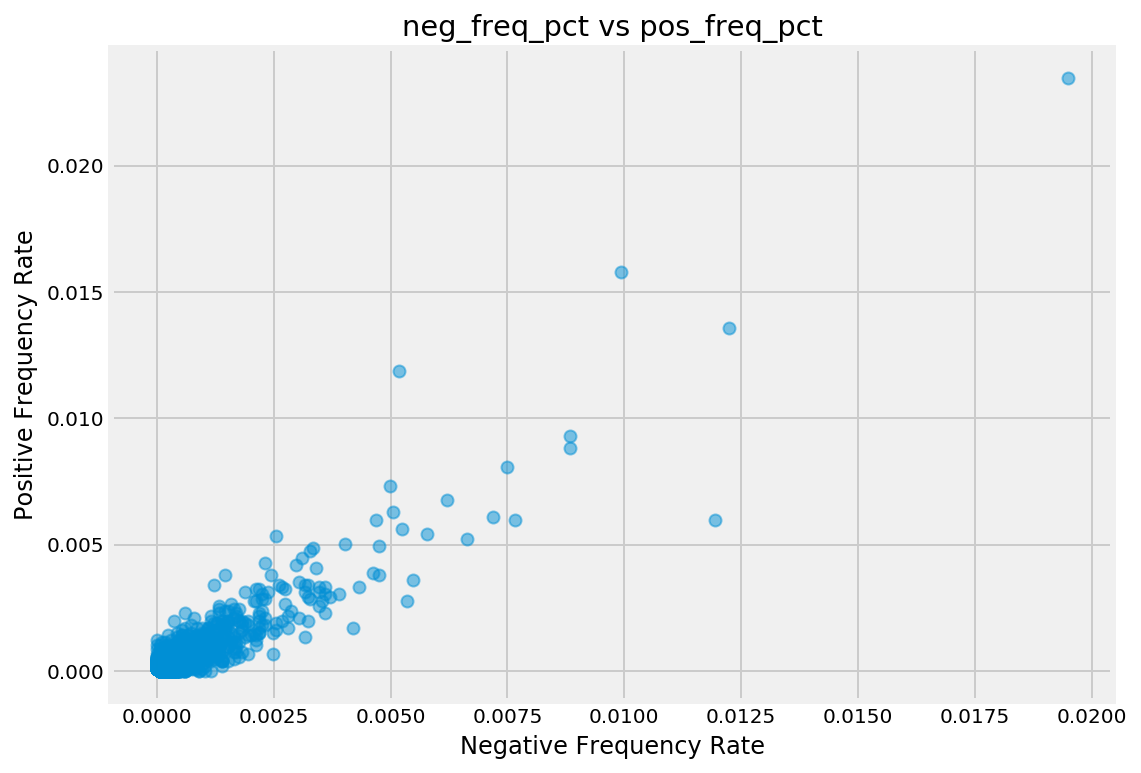

In [194]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_freq_pct", y="pos_freq_pct",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Frequency Rate')
plt.xlabel('Negative Frequency Rate')
plt.title('neg_freq_pct vs pos_freq_pct')

Text(0.5, 1.0, 'neg_hmean vs pos_hmean')

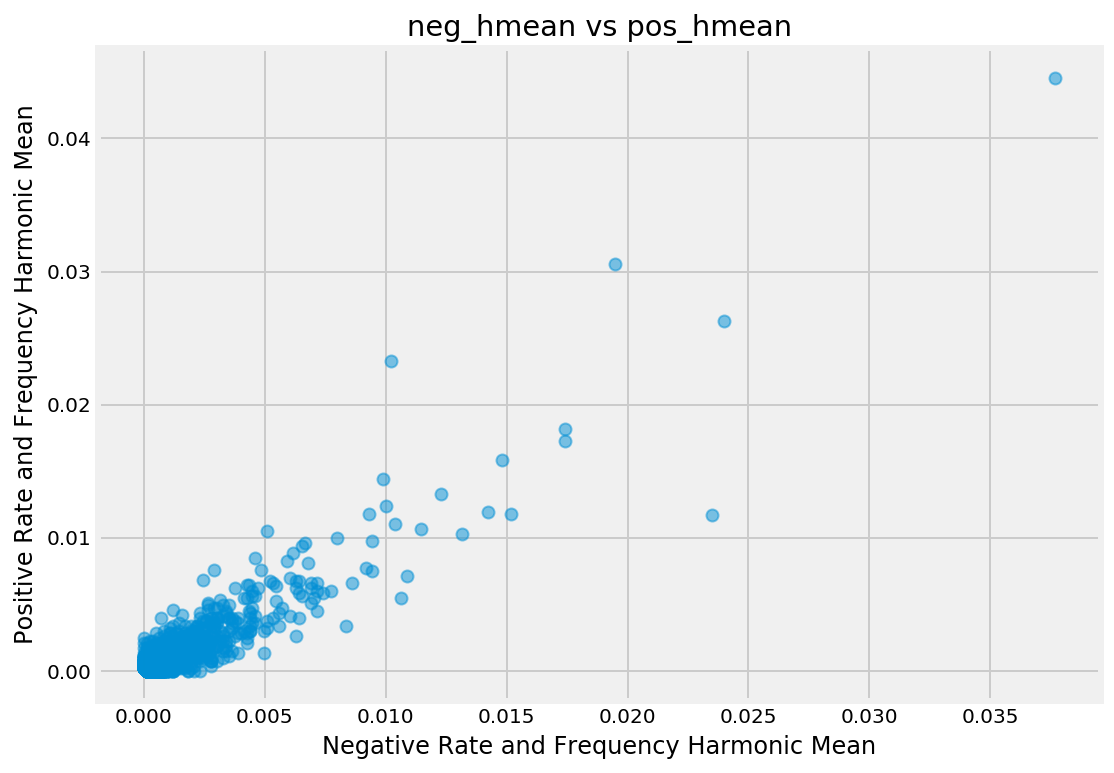

In [195]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_hmean", y="pos_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency Harmonic Mean')
plt.xlabel('Negative Rate and Frequency Harmonic Mean')
plt.title('neg_hmean vs pos_hmean')

Text(0.5, 1.0, 'neg_normcdf_hmean vs pos_normcdf_hmean')

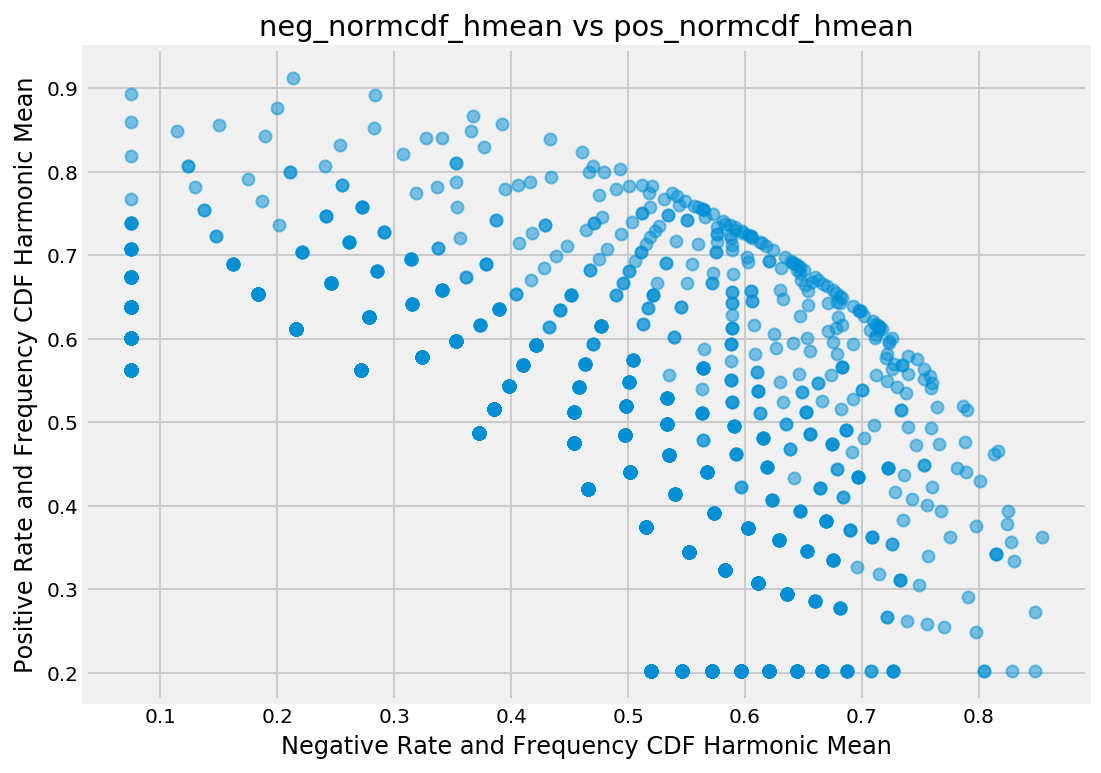

In [196]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x="neg_normcdf_hmean", y="pos_normcdf_hmean",fit_reg=False, scatter_kws={'alpha':0.5},data=term_freq_df2)
plt.ylabel('Positive Rate and Frequency CDF Harmonic Mean')
plt.xlabel('Negative Rate and Frequency CDF Harmonic Mean')
plt.title('neg_normcdf_hmean vs pos_normcdf_hmean')

In [198]:
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.models import LinearColorMapper
output_notebook()
from bokeh.resources import INLINE
import bokeh.io


color_mapper = LinearColorMapper(palette='Inferno256', low=min(term_freq_df2.pos_normcdf_hmean), high=max(term_freq_df2.pos_normcdf_hmean))
p = figure(x_axis_label='neg_normcdf_hmean', y_axis_label='pos_normcdf_hmean')
p.circle('neg_normcdf_hmean','pos_normcdf_hmean',size=5,alpha=0.3,source=term_freq_df2,color={'field': 'pos_normcdf_hmean', 'transform': color_mapper})
from bokeh.models import HoverTool
hover = HoverTool(tooltips=[('token','@index')])
p.add_tools(hover)
show(p)

Loading BokehJS ...

In [199]:
train_corpus,test_corpus,train_labels,test_labels = train_test_split(train_data,train_labels,stratify=train_labels,test_size=0.25,random_state=1)
train_texts, train_labels, test_texts, test_labels = train_corpus, train_labels, test_corpus, test_labels
x_train, y_train, x_validation, y_validation = train_corpus,train_labels,test_corpus,test_labels

In [200]:
y_train_len0 = 0
y_train_len1 = 1
for label in y_train:
    if label == 1:
        y_train_len1 += 1
    else:
        y_train_len0 += 1
        
y_val_len0 = 0
y_val_len1 = 0
for label in y_validation:
    if label == 1:
        y_val_len1 += 1
    else:
        y_val_len0 += 1

In [201]:
print( "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_train),
                                                                             (y_train_len0 / (len(x_train)*1.))*100,
                                                                            (y_train_len1 / (len(x_train)*1.))*100))
       
                                                                            
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(x_validation),
                                                                             (y_val_len0 / (len(x_validation)))*100,
                                                                            (y_val_len1 / (len(x_validation)))*100))

Train set has total 540 entries with 59.07% negative, 41.11% positive
Validation set has total 180 entries with 58.89% negative, 41.11% positive


In [202]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if y_val_len0 / (len(x_test)*1.) > 0.5:
        null_accuracy =  y_val_len1/ (len(x_test)*1.)
    else:
        null_accuracy = 1. - (y_val_len1 / (len(x_test)*1.))
    #t0 = time.time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    #train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    #print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy

In [216]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
cvec = CountVectorizer()
lr = LogisticRegression(max_iter=200)
n_features = np.arange(1000,4001,1000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy))
    return result

In [217]:
from sklearn.feature_extraction import text
z = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[:3].index))
c = frozenset(list(term_freq_df.sort_values(by='total', ascending=False).iloc[4:11].index))
listofsets = [z,c]
a = frozenset.union(*listofsets)
b = text.ENGLISH_STOP_WORDS
set(a).issubset(set(b))

True

In [218]:
my_stop_words = a

In [219]:
print("RESULT FOR UNIGRAM WITHOUT STOP WORDS\n")
feature_result_wosw = nfeature_accuracy_checker(stop_words='english')

RESULT FOR UNIGRAM WITHOUT STOP WORDS

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 65.00%
model is 23.89% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 63.89%
model is 22.78% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 63.33%
model is 22.22% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 62.22%
model is 21.11% more accurate than null accuracy
--------------------------------------------------------------------------------


In [220]:
print("RESULT FOR UNIGRAM WITH STOP WORDS\n")
feature_result_ug = nfeature_accuracy_checker()

RESULT FOR UNIGRAM WITH STOP WORDS

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 60.56%
model is 19.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 61.11%
model is 20.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 61.11%
model is 20.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 61.67%
model is 20.56% more accurate than null accuracy
--------------------------------------------------------------------------------


In [221]:
print("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)\n")
feature_result_wocsw = nfeature_accuracy_checker(stop_words=my_stop_words)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Top 10 frequent words)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 63.33%
model is 22.22% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 62.78%
model is 21.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 63.33%
model is 22.22% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 62.22%
model is 21.11% more accurate than null accuracy
--------------------------------------------------------------------------------


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


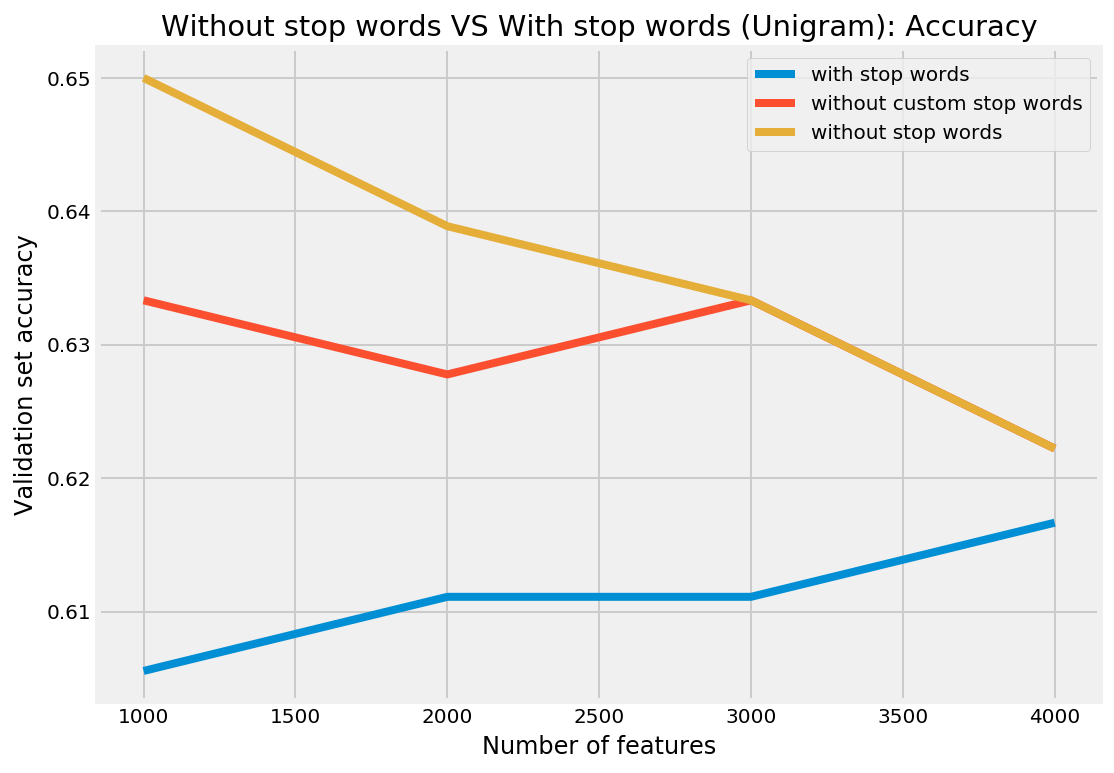

In [222]:
nfeatures_plot_ug = pd.DataFrame(feature_result_ug,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_wocsw = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug_wosw = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='with stop words')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy,label='without custom stop words')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy,label='without stop words')
plt.title("Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [223]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg = nfeature_accuracy_checker(stop_words=my_stop_words,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 62.22%
model is 21.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 60.56%
model is 19.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 62.78%
model is 21.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 62.78%
model is 21.67% more accurate than null accuracy
--------------------------------------------------------------------------------


In [224]:
print ("RESULT FOR BIGRAM WITH STOP WORDS\n")
feature_result_bg2 = nfeature_accuracy_checker(stop_words='english', ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 61.67%
model is 20.56% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 66.67%
model is 25.56% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 65.56%
model is 24.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 65.00%
model is 23.89% more accurate than null accuracy
--------------------------------------------------------------------------------


In [225]:
print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg = nfeature_accuracy_checker(stop_words=my_stop_words, ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 62.22%
model is 21.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 63.89%
model is 22.78% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 63.89%
model is 22.78% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 62.22%
model is 21.11% more accurate than null accuracy
--------------------------------------------------------------------------------


In [226]:
print("RESULT FOR TRIGRAM WITH STOP WORDS\n")
feature_result_tg2 = nfeature_accuracy_checker(stop_words='english', ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 62.22%
model is 21.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 67.22%
model is 26.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 66.11%
model is 25.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 66.67%
model is 25.56% more accurate than null accuracy
--------------------------------------------------------------------------------


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


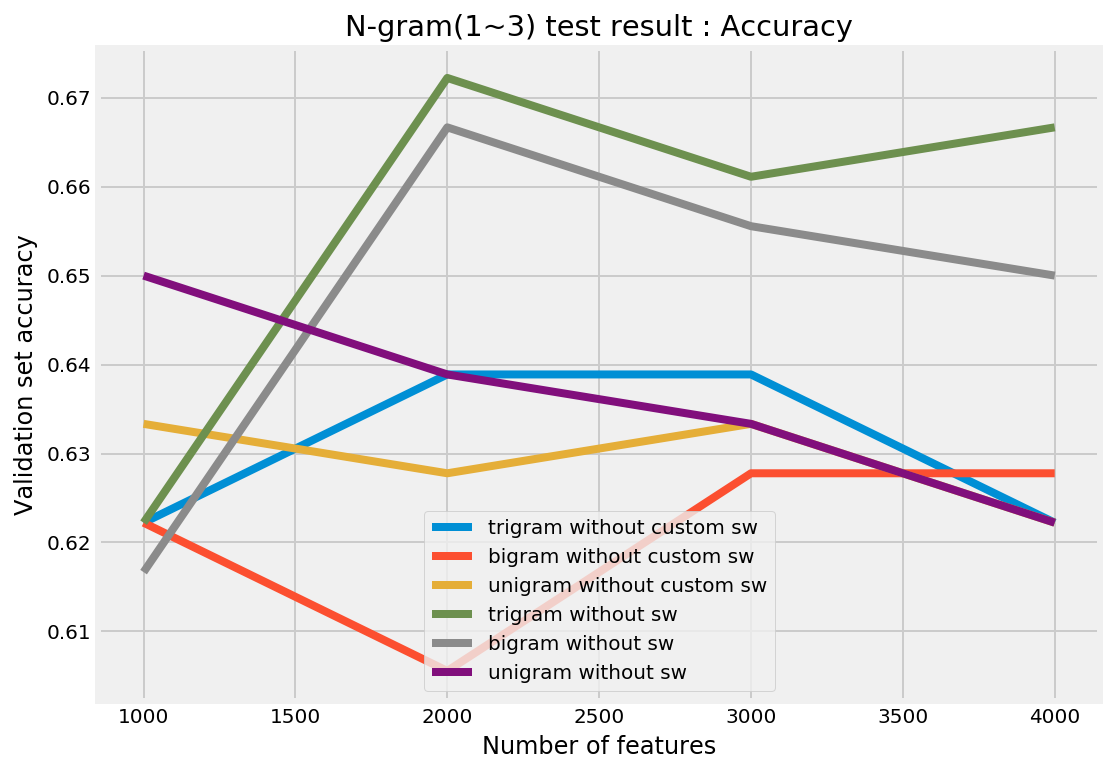

In [227]:
nfeatures_plot_tg = pd.DataFrame(feature_result_tg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg = pd.DataFrame(feature_result_bg,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug = pd.DataFrame(feature_result_wocsw,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_tg2 = pd.DataFrame(feature_result_tg2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg2 = pd.DataFrame(feature_result_bg2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ug2 = pd.DataFrame(feature_result_wosw,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram without custom sw')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram without custom sw')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram without custom sw')
plt.plot(nfeatures_plot_tg2.nfeatures, nfeatures_plot_tg2.validation_accuracy,label='trigram without sw')
plt.plot(nfeatures_plot_bg2.nfeatures, nfeatures_plot_bg2.validation_accuracy,label='bigram without sw')
plt.plot(nfeatures_plot_ug2.nfeatures, nfeatures_plot_ug2.validation_accuracy, label='unigram without sw')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [228]:
def train_test_and_evaluate(pipeline, x_train, y_train, x_test, y_test):
    if y_val_len0 / (len(x_test)*1.) > 0.5:
        null_accuracy =  y_val_len1/ (len(x_test)*1.)
    else:
        null_accuracy = 1. - (y_val_len1 / (len(x_test)*1.))
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    conmat = np.array(confusion_matrix(y_test, y_pred, labels=[0,1]))
    confusion = pd.DataFrame(conmat, index=['non_covid', 'covid'],
                         columns=['predicted_non_covid','predicted_covid'])
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print ("-"*80)
    print ("Confusion Matrix\n")
    print (confusion)
    print ("-"*80)
    print ("Classification Report\n")
    print (classification_report(y_test, y_pred, target_names=['negative','positive']))

In [229]:
%%time
tg_cvec = CountVectorizer(max_features=4000,ngram_range=(1, 3))
tg_pipeline = Pipeline([
        ('vectorizer', tg_cvec),
        ('classifier', lr)
    ])
train_test_and_evaluate(tg_pipeline, x_train, y_train, x_validation, y_validation)

null accuracy: 41.11%
accuracy score: 59.44%
model is 18.33% more accurate than null accuracy
--------------------------------------------------------------------------------
Confusion Matrix

           predicted_non_covid  predicted_covid
non_covid                   77               29
covid                       44               30
--------------------------------------------------------------------------------
Classification Report

              precision    recall  f1-score   support

    negative       0.64      0.73      0.68       106
    positive       0.51      0.41      0.45        74

    accuracy                           0.59       180
   macro avg       0.57      0.57      0.56       180
weighted avg       0.58      0.59      0.58       180

CPU times: user 336 ms, sys: 8.02 ms, total: 344 ms
Wall time: 346 ms


In [230]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()

In [231]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Tfidf)\n")
feature_result_ugt = nfeature_accuracy_checker(stop_words = my_stop_words,vectorizer=tvec)

RESULT FOR UNIGRAM WITHOUT CUSTOM STOP WORDS (Tfidf)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 67.78%
model is 26.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 69.44%
model is 28.33% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 69.44%
model is 28.33% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 67.78%
model is 26.67% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 235 ms, sys: 4.56 ms, total: 239 ms
Wall time: 242 

In [232]:
%%time
print ("RESULT FOR UNIGRAM WITHOUT STOP WORDS (Tfidf)\n")
feature_result_ugt2 = nfeature_accuracy_checker(stop_words = 'english',vectorizer=tvec)

RESULT FOR UNIGRAM WITHOUT STOP WORDS (Tfidf)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 72.22%
model is 31.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 69.44%
model is 28.33% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 70.00%
model is 28.89% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 68.33%
model is 27.22% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 203 ms, sys: 3.42 ms, total: 207 ms
Wall time: 205 ms


In [233]:
%%time
print ("RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_ugt3 = nfeature_accuracy_checker(vectorizer=tvec)

RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 63.33%
model is 22.22% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 67.78%
model is 26.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 67.22%
model is 26.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 66.11%
model is 25.00% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 232 ms, sys: 3.88 ms, total: 236 ms
Wall time: 235 ms


In [234]:
%%time
print ("RESULT FOR BIGRAM WITHOUT CUSTOM STOP WORDS (Tfidf)\n")
feature_result_bgt = nfeature_accuracy_checker(stop_words = my_stop_words,vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAM WITHOUT CUSTOM STOP WORDS (Tfidf)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 64.44%
model is 23.33% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 68.33%
model is 27.22% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 68.89%
model is 27.78% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 70.00%
model is 28.89% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 507 ms, sys: 12.4 ms, total: 520 ms
Wall time: 521 m

In [235]:
%%time
print ("RESULT FOR BIGRAM WITHOUT STOP WORDS (Tfidf)\n")
feature_result_bgt2 = nfeature_accuracy_checker(stop_words = 'english',vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAM WITHOUT STOP WORDS (Tfidf)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 70.00%
model is 28.89% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 70.00%
model is 28.89% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 69.44%
model is 28.33% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 68.89%
model is 27.78% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 371 ms, sys: 6.46 ms, total: 377 ms
Wall time: 376 ms


In [236]:
%%time
print ("RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_bgt3 = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 63.33%
model is 22.22% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 66.67%
model is 25.56% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 66.11%
model is 25.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 67.22%
model is 26.11% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 541 ms, sys: 11.9 ms, total: 553 ms
Wall time: 553 ms


In [237]:
%%time
print ("RESULT FOR TRIGRAM WITHOUT CUSTOM  STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(stop_words = my_stop_words,vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITHOUT CUSTOM  STOP WORDS (Tfidf)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 65.56%
model is 24.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 67.78%
model is 26.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 68.33%
model is 27.22% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 69.44%
model is 28.33% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 871 ms, sys: 24.7 ms, total: 896 ms
Wall time: 899

In [238]:
%%time
print ("RESULT FOR TRIGRAM WITHOUT STOP WORDS (Tfidf)\n")
feature_result_tgt2 = nfeature_accuracy_checker(stop_words = 'english',vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITHOUT STOP WORDS (Tfidf)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 70.56%
model is 29.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 71.11%
model is 30.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 70.00%
model is 28.89% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 68.89%
model is 27.78% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 570 ms, sys: 9.8 ms, total: 580 ms
Wall time: 581 ms


In [239]:
%%time
print ("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt3 = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 62.78%
model is 21.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 66.11%
model is 25.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 66.11%
model is 25.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 66.67%
model is 25.56% more accurate than null accuracy
--------------------------------------------------------------------------------
CPU times: user 989 ms, sys: 25.2 ms, total: 1.01 s
Wall time: 1.02 s


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


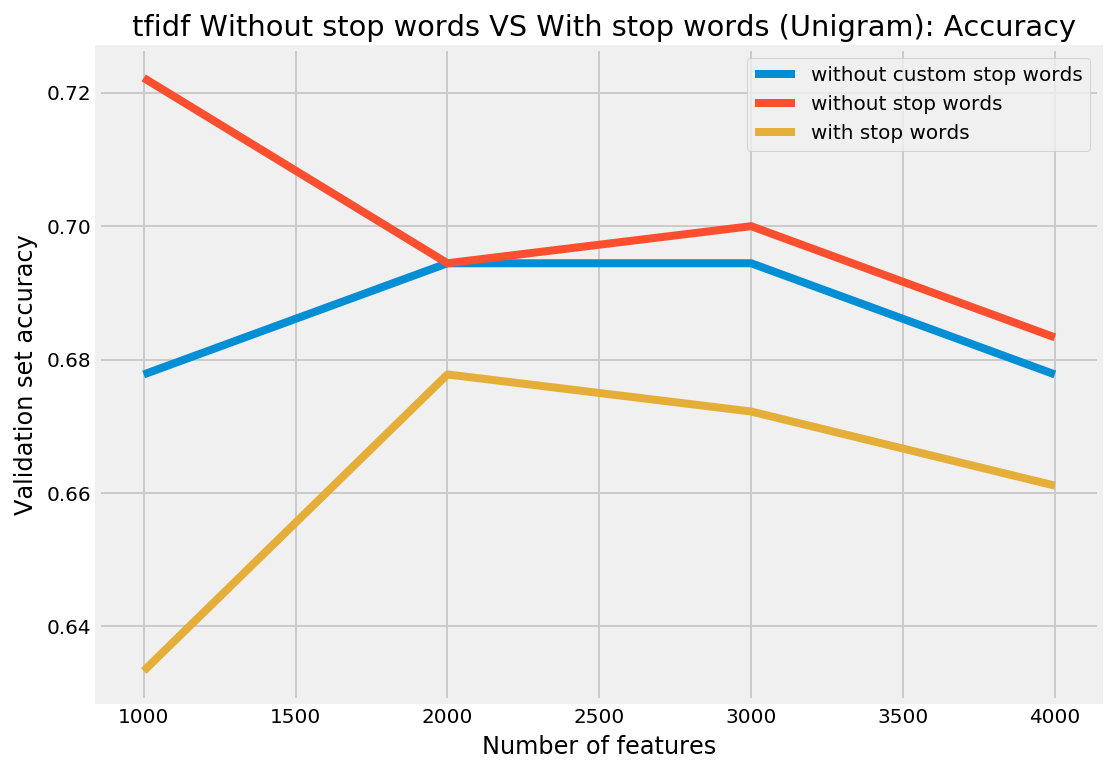

In [240]:
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt2 = pd.DataFrame(feature_result_ugt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt3 = pd.DataFrame(feature_result_ugt3,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='without custom stop words')
plt.plot(nfeatures_plot_ugt2.nfeatures, nfeatures_plot_ugt2.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_ugt3.nfeatures, nfeatures_plot_ugt3.validation_accuracy,label='with stop words')
plt.title(" tfidf Without stop words VS With stop words (Unigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

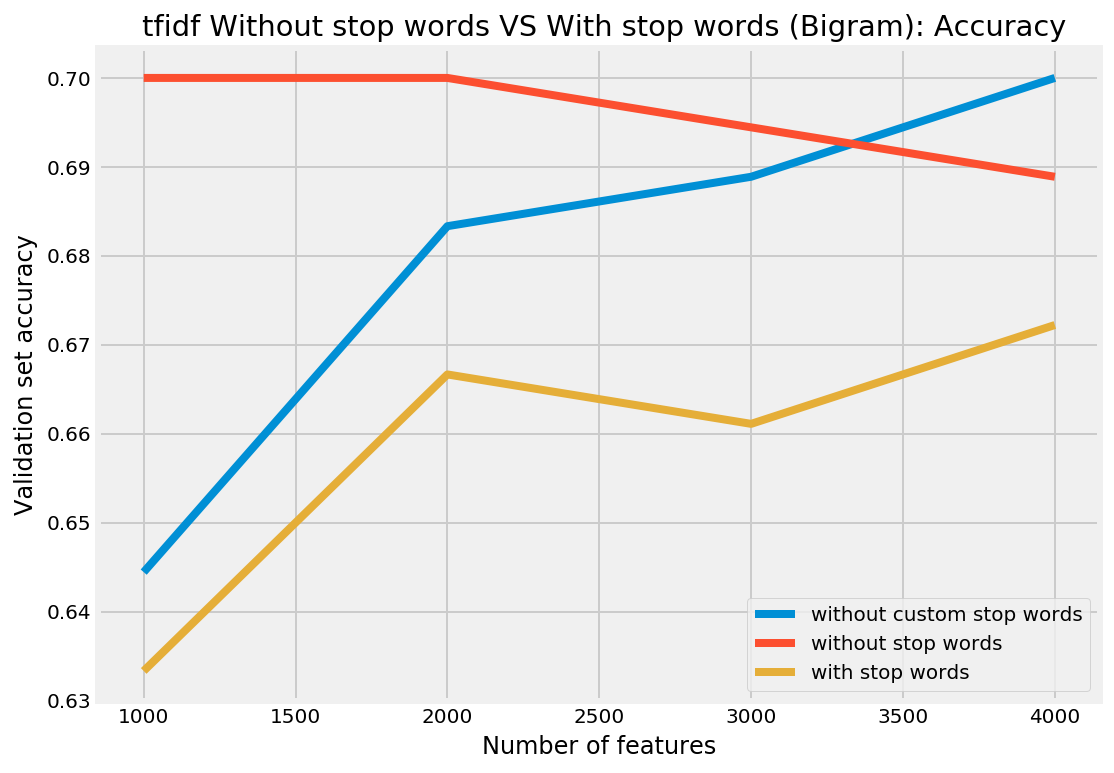

In [241]:
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt2 = pd.DataFrame(feature_result_bgt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt3 = pd.DataFrame(feature_result_bgt3,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy, label='without custom stop words')
plt.plot(nfeatures_plot_bgt2.nfeatures, nfeatures_plot_bgt2.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_bgt3.nfeatures, nfeatures_plot_bgt3.validation_accuracy,label='with stop words')
plt.title(" tfidf Without stop words VS With stop words (Bigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

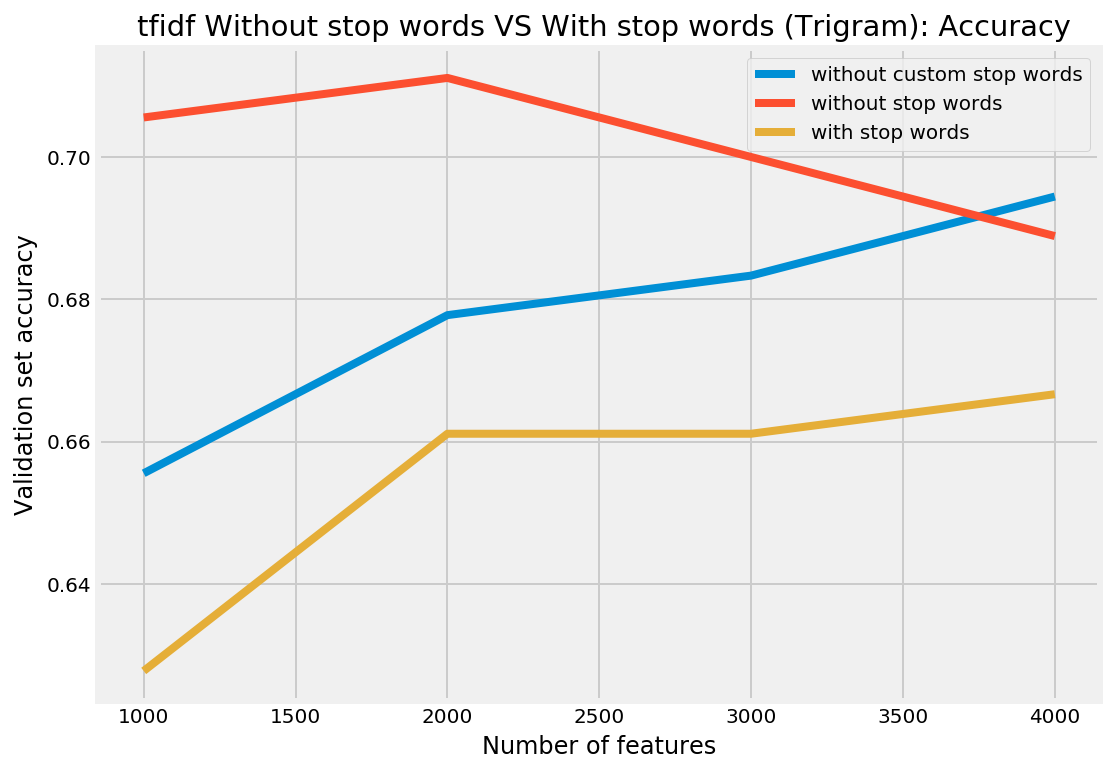

In [242]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_tgt2 = pd.DataFrame(feature_result_tgt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_tgt3 = pd.DataFrame(feature_result_tgt3,columns=['nfeatures','validation_accuracy'])
plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy, label='without custom stop words')
plt.plot(nfeatures_plot_tgt2.nfeatures, nfeatures_plot_tgt2.validation_accuracy,label='without stop words')
plt.plot(nfeatures_plot_tgt3.nfeatures, nfeatures_plot_tgt3.validation_accuracy,label='with stop words')
plt.title(" tfidf Without stop words VS With stop words (Trigram): Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

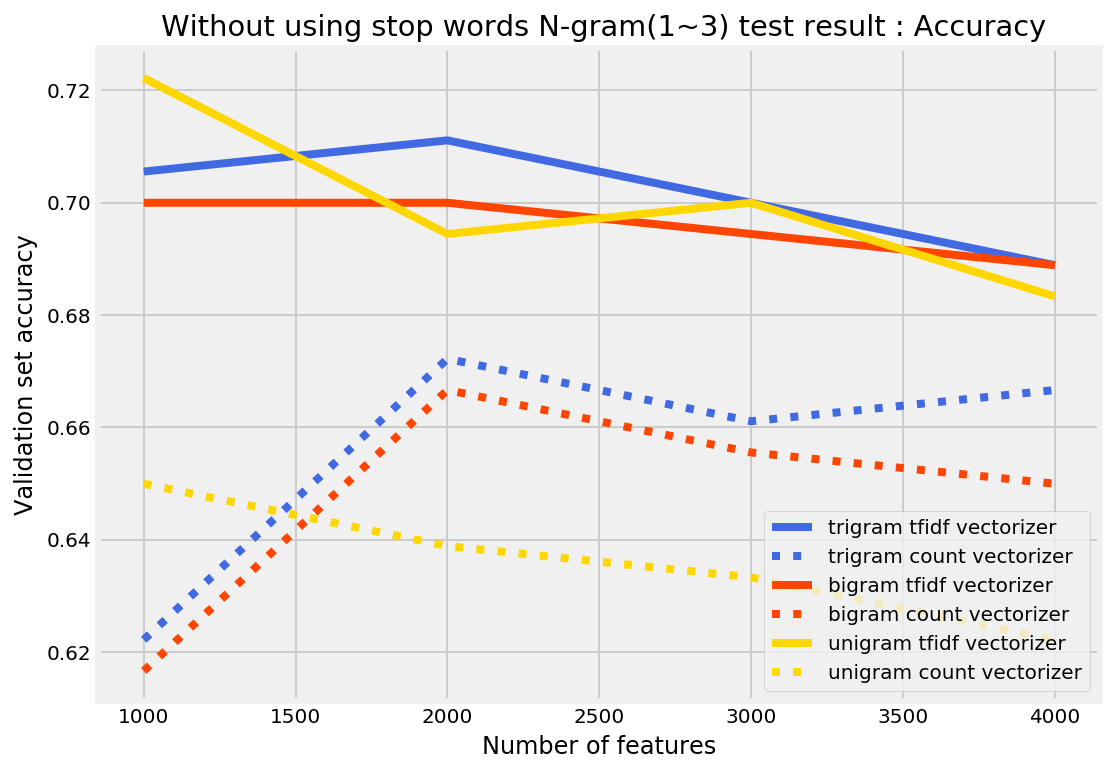

In [243]:
nfeatures_plot_tgt2 = pd.DataFrame(feature_result_tgt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt2 = pd.DataFrame(feature_result_bgt2,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt2 = pd.DataFrame(feature_result_ugt2,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt2.nfeatures, nfeatures_plot_tgt2.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg2.nfeatures, nfeatures_plot_tg2.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt2.nfeatures, nfeatures_plot_bgt2.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg2.nfeatures, nfeatures_plot_bg2.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt2.nfeatures, nfeatures_plot_ugt2.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug_wosw.nfeatures, nfeatures_plot_ug_wosw.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title(" Without using stop words N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

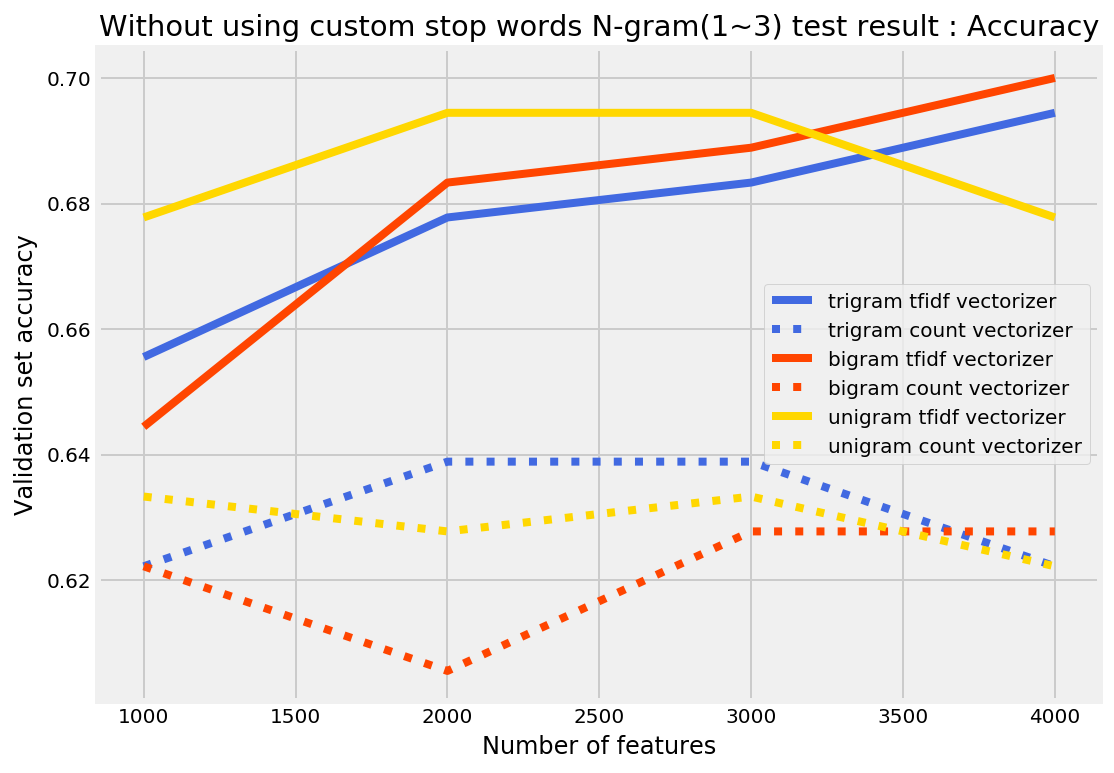

In [244]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg.nfeatures, nfeatures_plot_tg.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg.nfeatures, nfeatures_plot_bg.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug_wocsw.nfeatures, nfeatures_plot_ug_wocsw.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("Without using custom stop words N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [245]:
feature_result_bg3 = nfeature_accuracy_checker(ngram_range=(1, 2))
feature_result_tg3 = nfeature_accuracy_checker(ngram_range=(1, 3))

LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 56.67%
model is 15.56% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 2000 features
null accuracy: 41.11%
accuracy score: 57.22%
model is 16.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 3000 features
null accuracy: 41.11%
accuracy score: 57.78%
model is 16.67% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for 4000 features
null accuracy: 41.11%
accuracy score: 58.89%
model is 17.78% more accurate than null accuracy
--------------------------------------------------------------------------------
LogisticRegression(max_iter=200)


Validation result for 1000 features
null accuracy: 41.11%
accuracy score: 57.22%
model

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


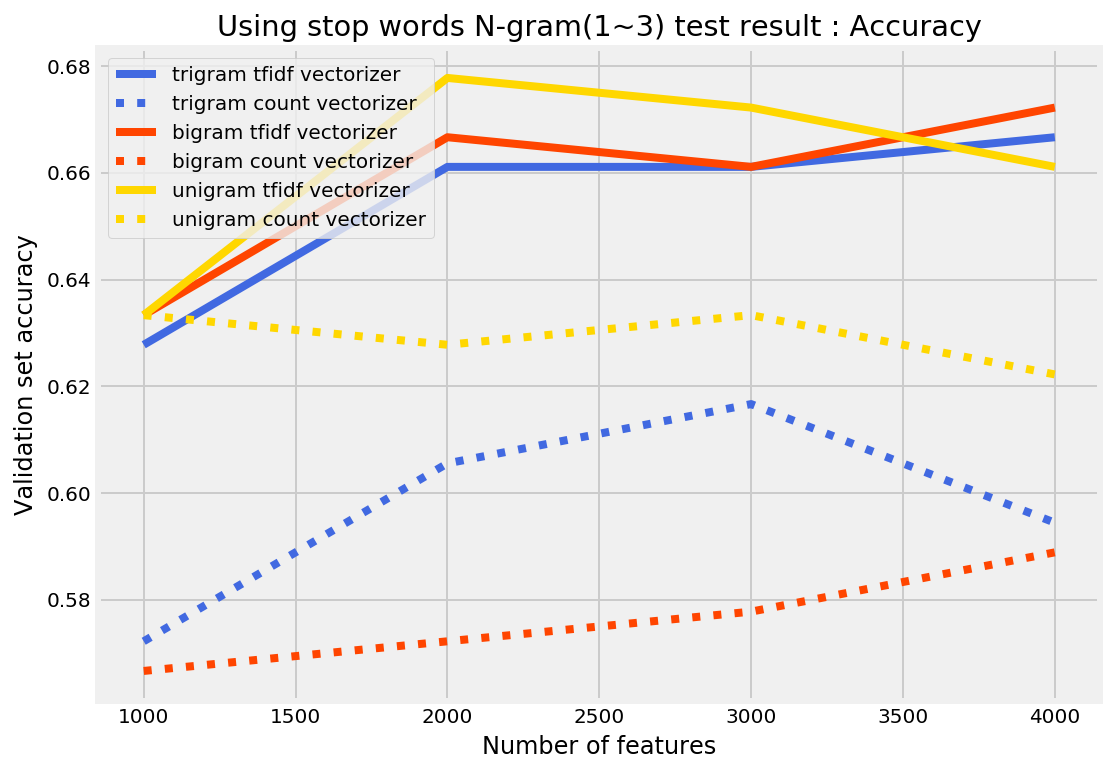

In [246]:
nfeatures_plot_tgt3 = pd.DataFrame(feature_result_tgt3,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bgt3 = pd.DataFrame(feature_result_bgt3,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_ugt3= pd.DataFrame(feature_result_ugt3,columns=['nfeatures','validation_accuracy'])

nfeatures_plot_tg3 = pd.DataFrame(feature_result_tg3,columns=['nfeatures','validation_accuracy'])
nfeatures_plot_bg3 = pd.DataFrame(feature_result_bg3,columns=['nfeatures','validation_accuracy'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt3.nfeatures, nfeatures_plot_tgt3.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_tg3.nfeatures, nfeatures_plot_tg3.validation_accuracy,label='trigram count vectorizer',linestyle=':', color='royalblue')
plt.plot(nfeatures_plot_bgt3.nfeatures, nfeatures_plot_bgt3.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_bg3.nfeatures, nfeatures_plot_bg3.validation_accuracy,label='bigram count vectorizer',linestyle=':',color='orangered')
plt.plot(nfeatures_plot_ugt3.nfeatures, nfeatures_plot_ugt3.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.plot(nfeatures_plot_ug.nfeatures, nfeatures_plot_ug.validation_accuracy, label='unigram count vectorizer',linestyle=':',color='gold')
plt.title("Using stop words N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

In [247]:
def accuracy_summary2(pipeline, x_train, y_train, x_test, y_test):
    if y_val_len0 / (len(x_test)*1.) > 0.5:
        null_accuracy =  y_val_len1/ (len(x_test)*1.)
    else:
        null_accuracy = 1. - (y_val_len1 / (len(x_test)*1.))
    #t0 = time.time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    #train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print ("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print ("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print ("model has the same accuracy with the null accuracy")
    else:
        print ("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    #print ("train and test time: {0:.2f}s".format(train_test_time))
    print ("-"*80)
    return accuracy, sentiment_fit

In [251]:
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression

clf1 = LogisticRegression()
clf2 = LinearSVC()
clf3 = MultinomialNB()
clf4 = RidgeClassifier()
clf5 = PassiveAggressiveClassifier()

eclf = VotingClassifier(estimators=[('lr', clf1), ('svc', clf2), ('mnb', clf3), ('rcs', clf4), ('pac', clf5)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, clf4, clf5, eclf], ['Logistic Regression', 'Linear SVC', 'Multinomial NB', 'Ridge Classifier', 'Passive Aggresive Classifier', 'Ensemble']):
    checker_pipeline = Pipeline([
            ('vectorizer', TfidfVectorizer(stop_words = 'english',max_features=2000,ngram_range=(1, 3))),
            ('classifier', clf)
        ])
    print ("Validation result for {}".format(label))
    print (clf)
    clf_accuracy, model = accuracy_summary2(checker_pipeline, x_train, y_train, x_validation, y_validation)

Validation result for Logistic Regression
LogisticRegression()
null accuracy: 41.11%
accuracy score: 71.11%
model is 30.00% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC()
null accuracy: 41.11%
accuracy score: 72.22%
model is 31.11% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB()
null accuracy: 41.11%
accuracy score: 70.00%
model is 28.89% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier()
null accuracy: 41.11%
accuracy score: 70.56%
model is 29.44% more accurate than null accuracy
--------------------------------------------------------------------------------
Validation result for Passive Aggresive Classifier
PassiveAggressiveClassifier()
n